In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import scipy.optimize as opt
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_cat import char_func_cat

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from scipy.interpolate import interp2d

In [3]:
def load_data_no_average(path: str, file_end: str, plot = True): 
    """_summary_

    Args:
        path (str): folder where files are located
        file_end (str): ending of files to load
        
    Returns:
        dd (dict): keys are time stamps and value is a non averaged data set of size (number of total reps, x, y)
    """
    fps = []
    fp = [path + f for f in os.listdir(path) if f.endswith(file_end)]
    fps = np.concatenate([fp[:]])
    
    dg = []
    de = []
    dts = []
    for kk in range(len(fps)):
        df = h5py.File(fps[kk], "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0, 0]
        y = data["y"][0, :, 0]
        dt = df.attrs['decay_time']
        thresh = -6.687025253601604e-06
#         ss_data = np.where(data_i < thresh, 1, 0)
#         thresh_1 = 6.30337300715842e-05
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)
        ## I only care about the double selected data!
        ## I use filled to replace all masked arrays with nan. This allows me to not care about masks after this point. This is useful, as i can later use np.nanmean to calculate the mean value.
        double_ps_g = ma.masked_array(m2_g, mask=m1_g, dtype='float').filled(np.nan).reshape(df.attrs["reps"],len(x), len(y)) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g), dtype='float').filled(np.nan).reshape(df.attrs["reps"], len(x), len(y)) * 2 - 1
        dg.append(double_ps_g)
        de.append(double_ps_e)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    
    dd = {}
    # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    # use dts to sort the values by decay time into the correct bin
    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
      
    # stack all arrays that were in the list
    for dt in decay_times:
        dd[str(dt)] = np.vstack(np.array(dd[str(dt)]))
    
    rows = 1
    cols = len(decay_times)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    # for i in range(rows):
    for j in range(cols):
        
        axes[j].pcolormesh(x, x, np.nanmean(dd[str(decay_times[j])][:, :], axis = 0), cmap="seismic", shading = 'auto', vmax=1, vmin=-1)
        axes[j].set_aspect("equal")
        axes[j].set_title(str(decay_times[j]))     
    plt.show()
    return dd, decay_times, x, y 
    
def bootstrap_resample(X):
    n = shape(X)[0]
    X_resample = np.zeros_like(X.T)
    XT = X.T.copy()

    resample_i = np.floor(np.random.rand(n)*n).astype(int)
    for x in range(shape(X)[1]):
        for y in range(shape(X)[2]):
                      
                X_resample[:][y][x] = XT[y][x][resample_i]
    return X_resample.T
    
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def cut_indexes(y_inter,angle):
    k = np.tan(angle)
    max_y_index = np.max(y_inter) # define maximal y_index allowed
    max_x_index = max_y_index
    xvec_fine = np.linspace(0, max_x_index, len(y_inter))
    for i, x in enumerate(xvec_fine):
        if np.abs(x*k)>max_y_index:
            max_x_index = xvec_fine[i-1]
            break
    x_indicies = np.linspace(-max_x_index, max_x_index, len(y_inter))
    y_indicies = x_indicies*k
    return x_indicies, y_indicies
    


def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))

In [4]:
# quick comment on plot error handling. introduced flag that is set to true if there is a plotting error. this will result in skipping the rest of the code and the reptition in which the error happend is not taken into account.

# defautl p0_angles are for cat
def extract_angle_bootstrap(dd, decay_times, x, y, n_reps, plot=False, bootstrap=True, p0_angles = [0,0,0,0,0,0,0,0,0,0]):
    
    
    # dictionary in which the angle results will be saved
    fitted_angles = {}
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            fitted_angles[str(decay_times[n])] = []

    
    data_dict = dd
    for rep in range(n_reps):
        plot_error = False
        if bootstrap:
            dd_bt = {}
            # resample data and saved resampled data in new dictionary
            for j in range(len(decay_times)):
                dd_bt[str(decay_times[j])] = bootstrap_resample(dd[str(decay_times[j])])
            data_dict = dd_bt
        
        if plot:
            fig, axs = plt.subplots(1, len(decay_times), figsize = (16, 20), sharey="row",)
        # those angles are found by first plotting the data and using the found angles in the fit..    
        
        
        print("Run Number:", rep)
        for i, time in enumerate(decay_times):
            
            scaling = 3
            xvec = x*scaling # i define it like this in case i want to slice x
            yvec = x*scaling
            X, Y = np.meshgrid(yvec, xvec)

            #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
            initial_guess = (0.8,  0.8, 0.8, 1.5, p0_angles[i], -0.08301675) # upper blob
            data = np.nanmean(data_dict[str(decay_times[i])], axis = 0)
            try:
                popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
                # append the fitted data to a list which is the value to the corresponding time stamp key
                fitted_angles[str(time)].append(popt[4])


                data_fitted1 = char_func_cat((X, Y), *popt)
                if plot:
                    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
                    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
                    axs[i].set_aspect("equal")
                    axs[i].set_title(str(decay_times[i]))
            
            except RuntimeError:
                print(f"Runtime Error occured trying to fit cat in repetition {rep} for time {time}. Move on to next repetition")
        plt.show()
    return fitted_angles

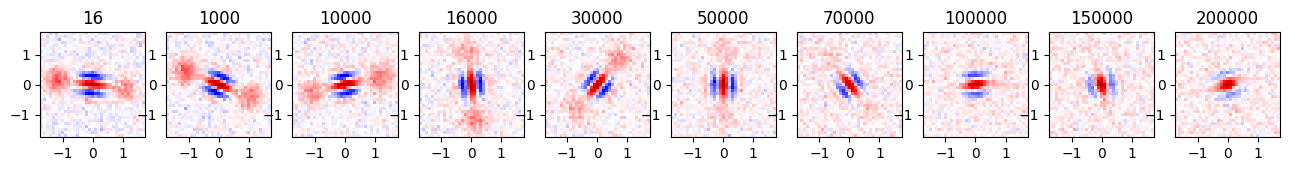

Run Number: 0
Runtime Error occured trying to fit cat in repetition 0 for time 100000. Move on to next repetition


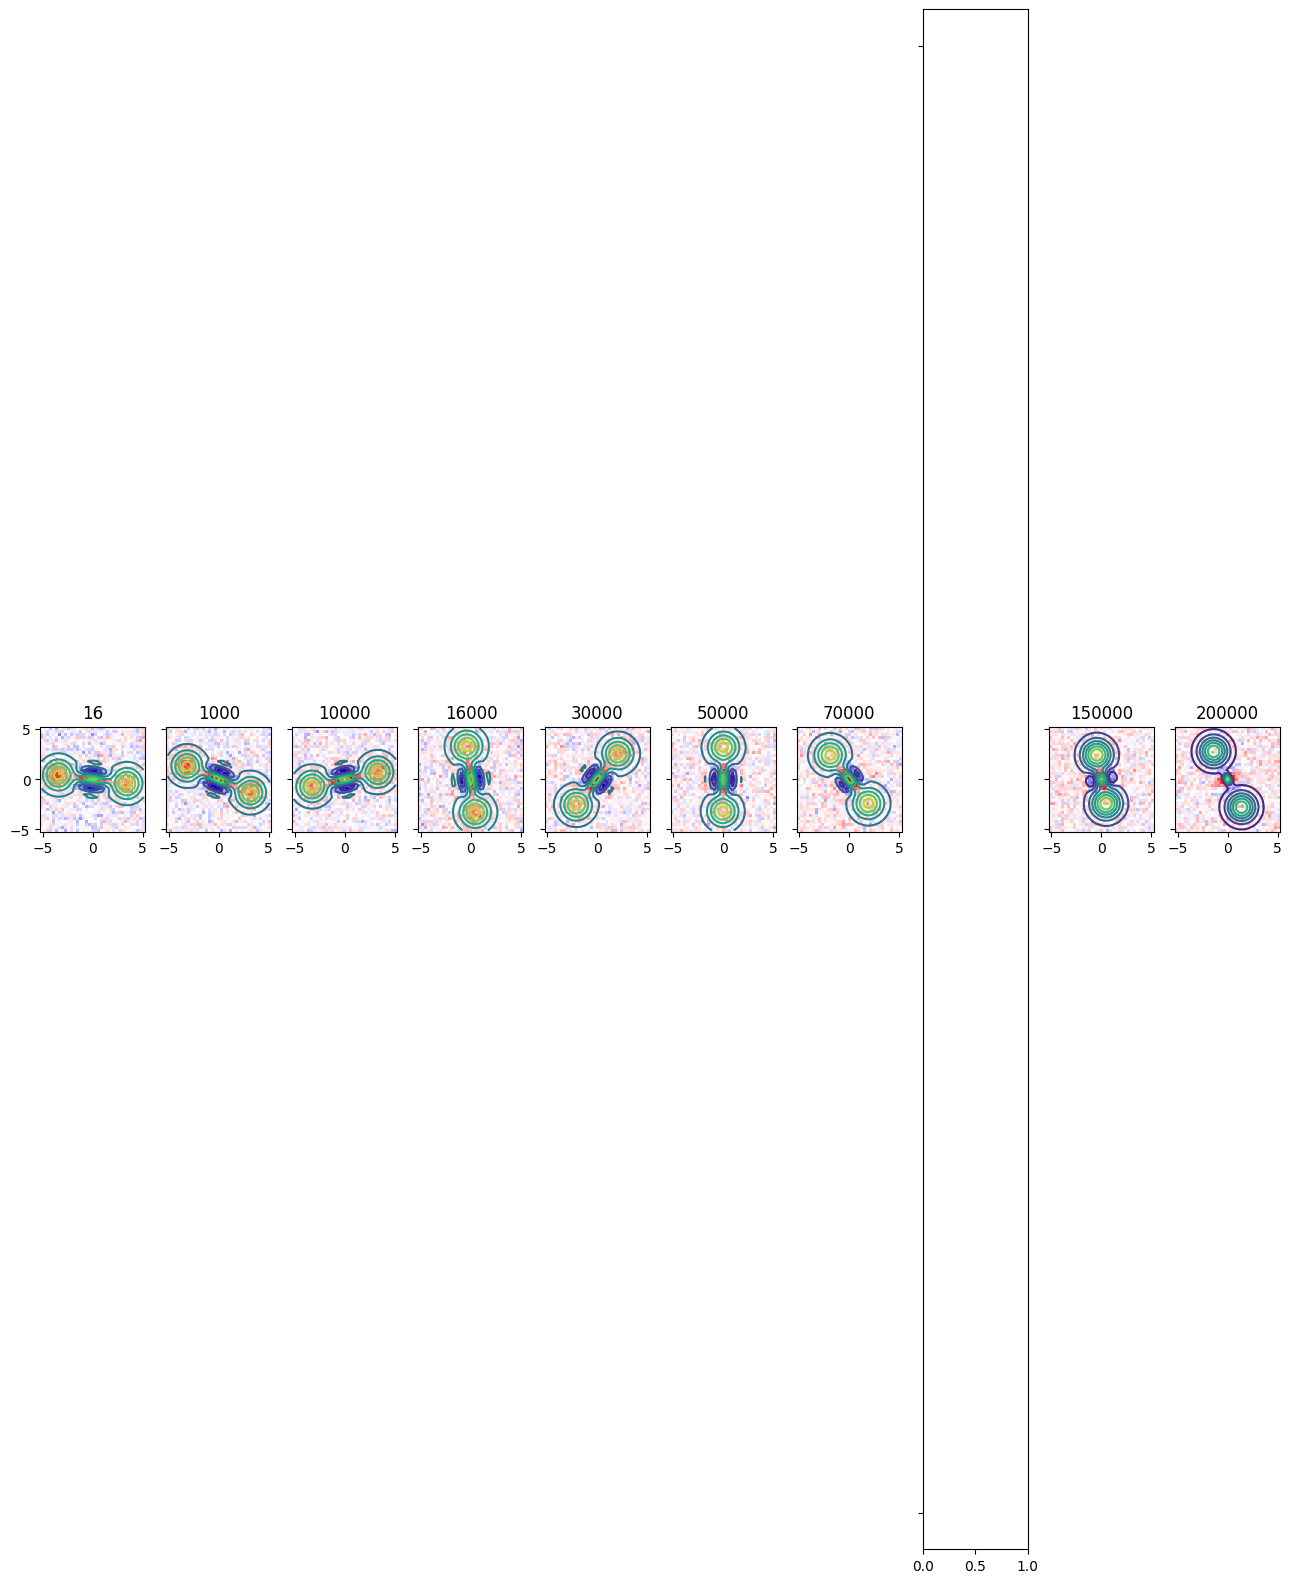

{'16': [1.6947847291722804], '1000': [-1.1728961975839374], '10000': [-1.784873591425537], '16000': [-0.12889199563253928], '30000': [0.6825680302864258], '50000': [0.012013968565827149], '70000': [-0.6707452227157256], '100000': [], '150000': [-0.18803065292123283], '200000': [-0.4635007635703497]}


In [13]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = 'cat_decay.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)
n_reps = 1
cat_blob_angles = extract_angle_bootstrap(dd, decay_times, x, y, n_reps, plot=True)
print(cat_blob_angles)

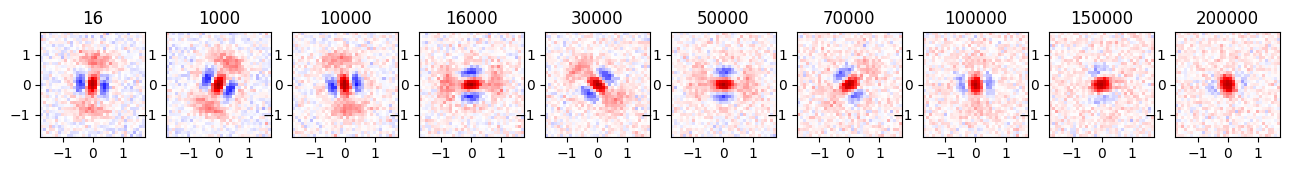

Run Number: 0


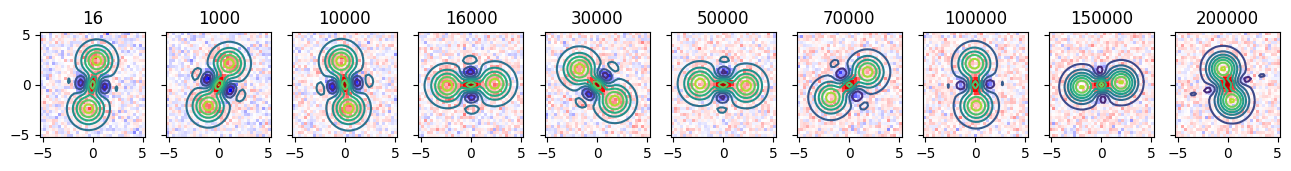

{'16': [0.17350299735427901], '1000': [3.601718467116944], '10000': [-0.1590760891463398], '16000': [1.5297581372886777], '30000': [-0.8363037180736239], '50000': [1.6203613078471448], '70000': [0.9627032713973657], '100000': [-0.04562247860904466], '150000': [1.4680186822333188], '200000': [-0.2683860983299932]}


In [95]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '3db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)
angles_7db = [0.09, 0.36, -0.27, 1.41, -0.91, 1.5, 0.863, -0.1, 1.32, -0.43]
n_reps = 1
cat_blob_angles = extract_angle_bootstrap(dd, decay_times, x, y, n_reps, plot=True, p0_angles=angles_3db)
print(cat_blob_angles)

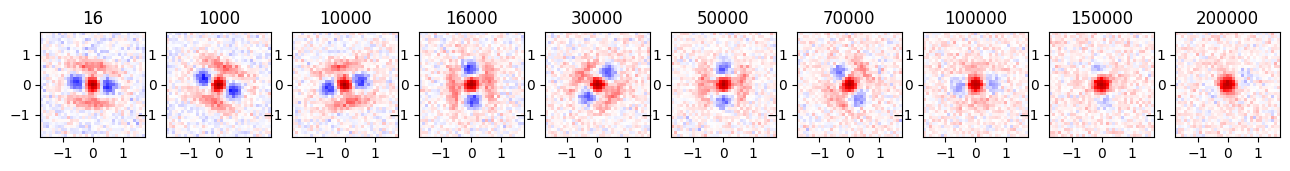

Run Number: 0


c:\Users\jonat\AppData\Local\pypoetry\Cache\virtualenvs\tcsim-vg60nFMD-py3.9\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


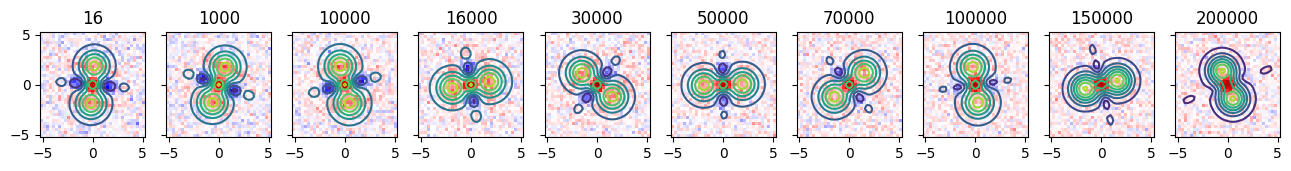

{'16': [0.08624135203136804], '1000': [3.481697932638462], '10000': [-0.24429717705676302], '16000': [1.4077137760789922], '30000': [-0.9084665399061014], '50000': [1.542284453636111], '70000': [0.891127071102532], '100000': [-0.1396559623530322], '150000': [1.3242310845972645], '200000': [-0.3653695793141961]}


In [96]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '6db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)
angles_7db = [0.09, 0.36, -0.27, 1.41, -0.91, 1.5, 0.863, -0.1, 1.32, -0.43]
n_reps = 1
cat_blob_angles = extract_angle_bootstrap(dd, decay_times, x, y, n_reps, plot=True, p0_angles=angles_3db)
print(cat_blob_angles)

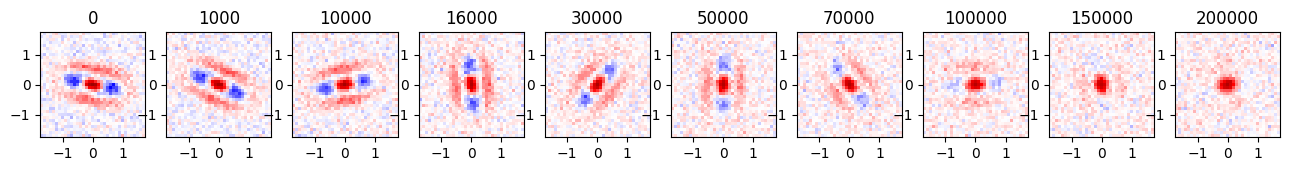

Run Number: 0


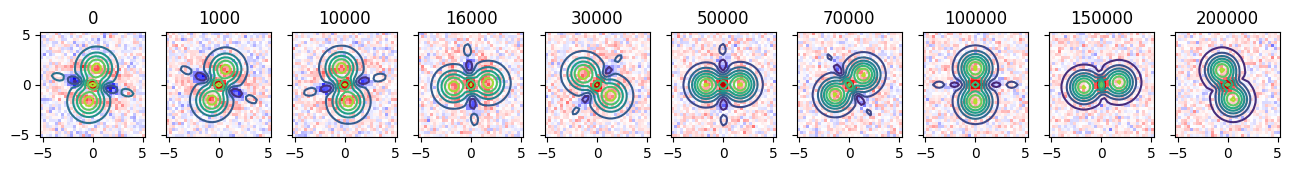

{'0': [0.22994483027890655], '1000': [0.4201298221468202], '10000': [-0.20320408851295202], '16000': [1.4724216952339215], '30000': [-0.8900962965924076], '50000': [1.5552904784142922], '70000': [0.9465968173313077], '100000': [0.0007105172024629204], '150000': [1.43727733761228], '200000': [-0.3580811071417076]}


In [98]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '7db.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)
angles_7db = [0.09, 0.36, -0.27, 1.41, -0.91, 1.5, 0.863, -0.1, 1.32, -0.43]
n_reps = 1
cat_blob_angles = extract_angle_bootstrap(dd, decay_times, x, y, n_reps, plot=True, p0_angles=angles_7db)
print(cat_blob_angles)

In [99]:
angles = [1.68, 1.96, 1.35, 3.02, 0.68, 3.16, 2.465, 1.47, 2.97, 1.16]
angles_3db = [0.14, 3.58, -0.16, 1.54, -0.82, 1.6, 0,-0.04, 1.5, -0.28]
angles_6db = [0.09, 0.36, -0.27, 0, -0.91, 0, 0.863, -0.1, 1.32, -0.43]
angles_7db = [0.06, 0.37, -0.254, 1.40, -0.91, 1.50, 0.83, -0.1, 1.37, -0.293]

### is there a relationship?

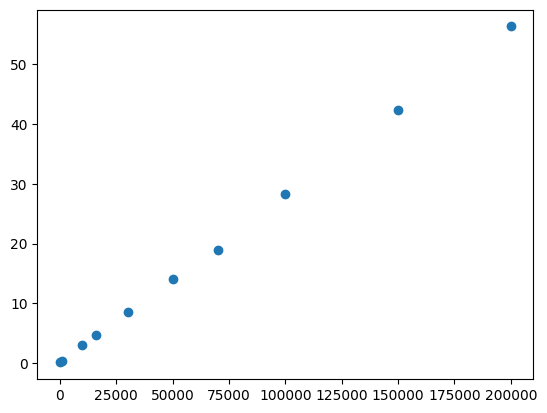

In [105]:
pis = np.array([0,-1,1,1,3,4,6,9,13,18])*np.pi
fit_angles = np.array(angles_3db) + pis
plt.plot(decay_times, fit_angles, 'o')

f= 44652.95251906831
theta = 0.07931430590812331


Text(0.5, 1.0, '7db')

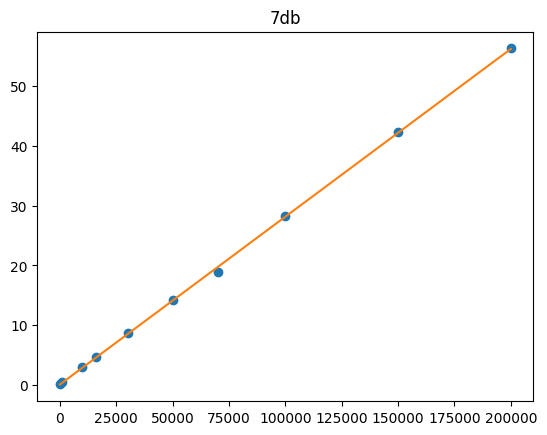

In [106]:
from scipy.optimize import curve_fit

def func(t,f,theta):
    return 2*np.pi*f*t+theta

popt, pcov = curve_fit(func,decay_times[:],fit_angles[:])

plt.plot(decay_times[:],fit_angles[:], "o")
plt.plot(decay_times[:],func(decay_times[:], *popt), )
print("f=", popt[0]*1e9)
print("theta =", popt[1])
plt.title("7db")


# how stable is it?

In [104]:
cat_blob_angles_mean = []
error_bars = []
for time in decay_times:
    cat_blob_angles_mean.append(np.mean(cat_blob_angles[str(time)]))
    error_bars.append(np.std(cat_blob_angles[str(time)]))

Text(0, 0.5, 'Angle in Rad')

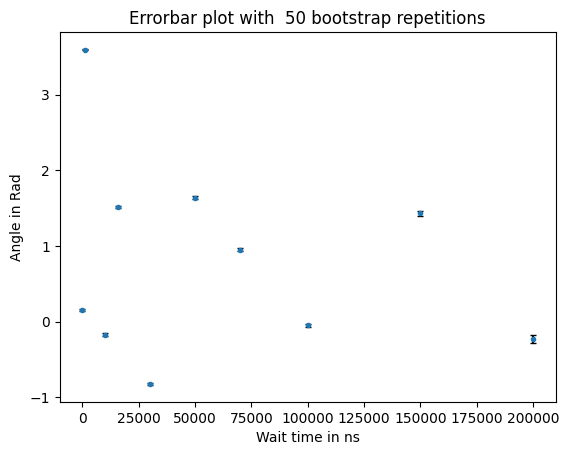

In [105]:


plt.errorbar(decay_times[:], cat_blob_angles_mean[:],yerr=error_bars,fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  {n_reps} bootstrap repetitions')
plt.xlabel('Wait time in ns')
plt.ylabel("Angle in Rad")

In [80]:
# Some plotting defaults

import matplotlib as mpl
import matplotlib.cm
import numpy as np


bwr = [(0.0, 0.0, 0.7), (0.1, 0.1, 1.0), (1.0, 1.0, 1.0), (1.0, 0.1, 0.1), (0.7, 0.0, 0.0)]
pcolor_cmap = mpl.colors.LinearSegmentedColormap.from_list('mymap', bwr, gamma=1)


cm = 1.0/2.54  # centimeters in inches

def general_figure():
    mpl.rcParams['figure.figsize'] = [10,8]
    mpl.rcParams['axes.linewidth'] = 1
    mpl.rcParams['xtick.major.size'] = 1.5
    mpl.rcParams['ytick.major.size'] = 1.5
    mpl.rcParams['xtick.minor.size'] = 1
    mpl.rcParams['ytick.minor.size'] = 1
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['xtick.minor.width'] = 0.8
    mpl.rcParams['ytick.minor.width'] = 0.8
    mpl.rcParams['font.sans-serif'] ='Arial'
    mpl.rcParams['font.size'] = 20
    mpl.rcParams['axes.labelsize']= 20
    mpl.rcParams['legend.fontsize'] = 20


def smallplot_halfcol_figs(): 
    ## for double column papers, half-column figure can take up to 8.6cm in width as a whole. 
    mpl.rcParams['figure.figsize'] = [1.6*cm, 3.2*cm]
    mpl.rcParams['axes.linewidth'] = 1
    mpl.rcParams['xtick.major.size'] = 2
    mpl.rcParams['ytick.major.size'] = 2
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['xtick.major.top'] = False
    mpl.rcParams['xtick.major.bottom'] = True
    mpl.rcParams['ytick.labelsize'] = 10
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['xtick.labelbottom'] = False
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.labelleft'] = False
    mpl.rcParams['ytick.direction'] = 'in'

def smallplot_halfcol_figs_square(): 
    ## for double column papers, half-column figure can take up to 8.6cm in width as a whole. 
    mpl.rcParams['figure.figsize'] = [3*cm, 3*cm]
    mpl.rcParams['axes.linewidth'] = 1
    mpl.rcParams['xtick.major.size'] = 2
    mpl.rcParams['ytick.major.size'] = 2
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['xtick.major.top'] = False
    mpl.rcParams['xtick.major.bottom'] = True
    mpl.rcParams['ytick.labelsize'] = 10
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['xtick.labelbottom'] = False
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.labelleft'] = False
    mpl.rcParams['ytick.direction'] = 'in'
    
def find_vmax(data):
    z_min = data.flatten().min()
    z_max = data.flatten().max()
    vmax = max(abs(z_min), abs(z_max))
    return vmax


colours_one  = [
     [0.05, 0.06, 0.08],
     [0.75, 0.  , 0.11],
     [0.44, 0.  , 0.51],
     [0.49, 0.81, 0.64],
     [0.77, 0.72, 0.57],
     [1.  , 0.42, 0.02],
     [0.59, 0.  , 0.25],
     [0.18, 0.38, 0.42],
     [0.75, 0.57, 0.11],
     [0.01, 0.45, 0.  ],
     [0.32, 0.29, 0.13],
     [0.29, 0.  , 0.  ],
     [0.98, 0.52, 0.53],
]
 
colours_two = [
  #  [0.90, 0.92, 0.92],
    [0.84, 0.17, 0.15],
    [0.10, 0.09, 0.09],
    [0.12, 0.19, 0.44],
    [0.47, 0.75, 0.65],
    [0.47, 0.03, 0.27],
    [0.5,  0.53, 0.53],
    [0.58, 0.3,  0.11],
    [0.89, 0.45, 0.55],
    [0.0,  0.44, 0.21],
    [0.0,  0.53, 0.75],
    [0.98, 0.78, 0.12],
]

def test_colours(c_list):
    xs = np.linspace(0, 1, 11)
    general_figure()
    for kk in range(len(xs)):
        plt.plot(xs, 2*xs[kk]*np.sin(xs), lw=4, color=c_list[kk], label = str(clist[kk]))
    plt.legend()